## Generative Adversarial Network  (When Fakes Get Real)

![](https://camo.githubusercontent.com/4c4f5a700b817b646bbed49dffdaa4a0925df8aa/68747470733a2f2f6d6f7276616e7a686f752e6769746875622e696f2f7374617469632f726573756c74732f746f7263682f342d342d312e676966)

In this two models will fight against each other and will be able to co-train through plain old `backpropagation`

The models play two distinct roles. Given some real data set R, G is the `generator`, trying to create fake data that looks just like the genuine data, while D is the `discriminator`, getting data from either the real set or G and labeling the difference. Goodfellow’s metaphor (and a fine one it is) was that G was like a team of forgers trying to match real paintings with their output, while D was the team of detectives trying to tell the difference. (Except that in this case, the forgers G never get to see the original data — only the judgments of D. They’re like blind forgers.) [to get more detail](https://medium.com/@devnag/generative-adversarial-networks-gans-in-50-lines-of-code-pytorch-e81b79659e3f)

![](https://cdn-images-1.medium.com/max/800/1*-gFsbymY9oJUQJ-A3GTfeg.png)

In the ideal case, both D and G would get better over time until G had essentially become a “master forger” of the genuine article and D was at a loss, “unable to differentiate between the two distributions.”

explaination credits - [Dev Nag](https://medium.com/@devnag/generative-adversarial-networks-gans-in-50-lines-of-code-pytorch-e81b79659e3f)


In [65]:
%pylab inline

import os
import numpy as np
import pandas as pd
from scipy.misc import imread

from keras.datasets import mnist
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Reshape, InputLayer
from keras.regularizers import L1L2
from keras.layers import Input
from keras_adversarial import AdversarialModel, simple_gan, gan_targets
from keras_adversarial import AdversarialOptimizerSimultaneous, normal_latent_sampling

Populating the interactive namespace from numpy and matplotlib


/home/rushil/.local/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['imread', 'seed']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [67]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()


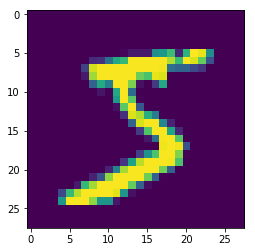

In [68]:
from matplotlib import pyplot as plt
plt.imshow(X_train[0])


In [69]:
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
train_x =X_train/ 255
X_test /= 255

In [70]:
train_x.shape[1:]

(1, 28, 28)

## GAN architecture
![](https://d3ansictanv2wj.cloudfront.net/GAN_Overall-7319eab235d83fe971fb769f62cbb15d.png)

In [71]:
g_input_shape = 100
d_input_shape = (28, 28) 
hidden_1_num_units = 500 
hidden_2_num_units = 500 
g_output_num_units = 784 
d_output_num_units = 1 
epochs = 25 
batch_size = 128

### Generative models are Deep convolutional in Nature; while Discriminative ones are deconvolutional

![](https://camo.githubusercontent.com/3f0526681587126784943a49fd7da4c1bd216ae4/68747470733a2f2f6169322d73322d7075626c69632e73332e616d617a6f6e6177732e636f6d2f666967757265732f323031362d31312d30382f343266366635343534646461393964383938396639383134393839656664353066653830376565382f332d466967757265312d312e706e67)

In [72]:
# generator
generator = Sequential([
    Dense(units=hidden_1_num_units, input_dim=g_input_shape, activation='relu', kernel_regularizer=L1L2(1e-5, 1e-5)),

    Dense(units=hidden_2_num_units, activation='relu', kernel_regularizer=L1L2(1e-5, 1e-5)),
        
    Dense(units=g_output_num_units, activation='sigmoid', kernel_regularizer=L1L2(1e-5, 1e-5)),
    
    Reshape(d_input_shape),
])


# discriminator
discriminator = Sequential([
    InputLayer(input_shape=d_input_shape),
    
    Flatten(),
        
    Dense(units=hidden_1_num_units, activation='relu', kernel_regularizer=L1L2(1e-5, 1e-5)),

    Dense(units=hidden_2_num_units, activation='relu', kernel_regularizer=L1L2(1e-5, 1e-5)),
        
    Dense(units=d_output_num_units, activation='sigmoid', kernel_regularizer=L1L2(1e-5, 1e-5)),
])

In [73]:
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 500)               50500     
_________________________________________________________________
dense_14 (Dense)             (None, 500)               250500    
_________________________________________________________________
dense_15 (Dense)             (None, 784)               392784    
_________________________________________________________________
reshape_3 (Reshape)          (None, 28, 28)            0         
Total params: 693,784
Trainable params: 693,784
Non-trainable params: 0
_________________________________________________________________


In [74]:
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28)            0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 500)               392500    
_________________________________________________________________
dense_17 (Dense)             (None, 500)               250500    
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 501       
Total params: 643,501
Trainable params: 643,501
Non-trainable params: 0
_________________________________________________________________


## GAN Model

In [89]:
from keras.models import Model
from keras.optimizers import Adam, SGD
opt = SGD(lr=1e-3)

def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
       l.trainable = val
make_trainable(discriminator, False)

# # Build stacked GAN model
gan_input = Input(shape=[100])
H = generator(gan_input)
gan_V = discriminator(H)
GAN = Model(gan_input, gan_V)
GAN.compile(loss='categorical_crossentropy',optimizer=opt)
GAN.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 100)               0         
_________________________________________________________________
sequential_5 (Sequential)    (None, 28, 28)            693784    
_________________________________________________________________
sequential_6 (Sequential)    (None, 1)                 643501    
Total params: 1,337,285
Trainable params: 693,784
Non-trainable params: 643,501
_________________________________________________________________


### yet to be continue.....